# Syntaxin-Binding Protein 1 (STXBP1) and Developmental and epileptic encephalopathy 4 (DEE4)

[Developmental and epileptic encephalopathy 4 (DEE4)](https://omim.org/entry/612164) is a neruological disorder that is typically autosomal dominant, but has been found to also occur as autosomal recessive. Onset typically happens in neonatal or infancy, showing symptoms such as many different types of seizures, developmental regression, impaired intellectual development, hypsarrhythmia, hypotonia, spastic para/quadriplegia, brain hypomyelination, cerebral atrophy, and West syndrome. The syndrome is caused by pathogenic variants in the [STXBP1](https://www.ncbi.nlm.nih.gov/gene/6812) gene.



[Xian et al. (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9166568/) stated that:

>  patients with R406H and R406C mutations were more likely to have a burst suppression pattern on EEG and spastic tetraplegia, and less likely to have ataxia, compared to the rest of the cohort. Additionally, patients with premature termination mutations or deletions in the STXBP1 gene were more likely to have infantile spasms, hypsarrhythmia on EEG, ataxia, hypotonia, and neonatal seizure onset compared to patients with missense mutations.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


### STXBP1
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for STXBP1.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'STXBP1'
mane_tx_id = 'NM_003165.6'
mane_protein_id = 'NP_003156.1'
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

qc.summarize()

Individuals Processed: 100%|██████████| 462/462 [00:00<00:00, 1255.12 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
230,Global developmental delay
152,Absent speech
143,Infantile spasms
120,Hypsarrhythmia
106,"Intellectual disability, severe"
93,Inability to walk
92,Generalized tonic seizure
86,Multifocal epileptiform discharges
77,Bilateral tonic-clonic seizure
75,EEG with burst suppression


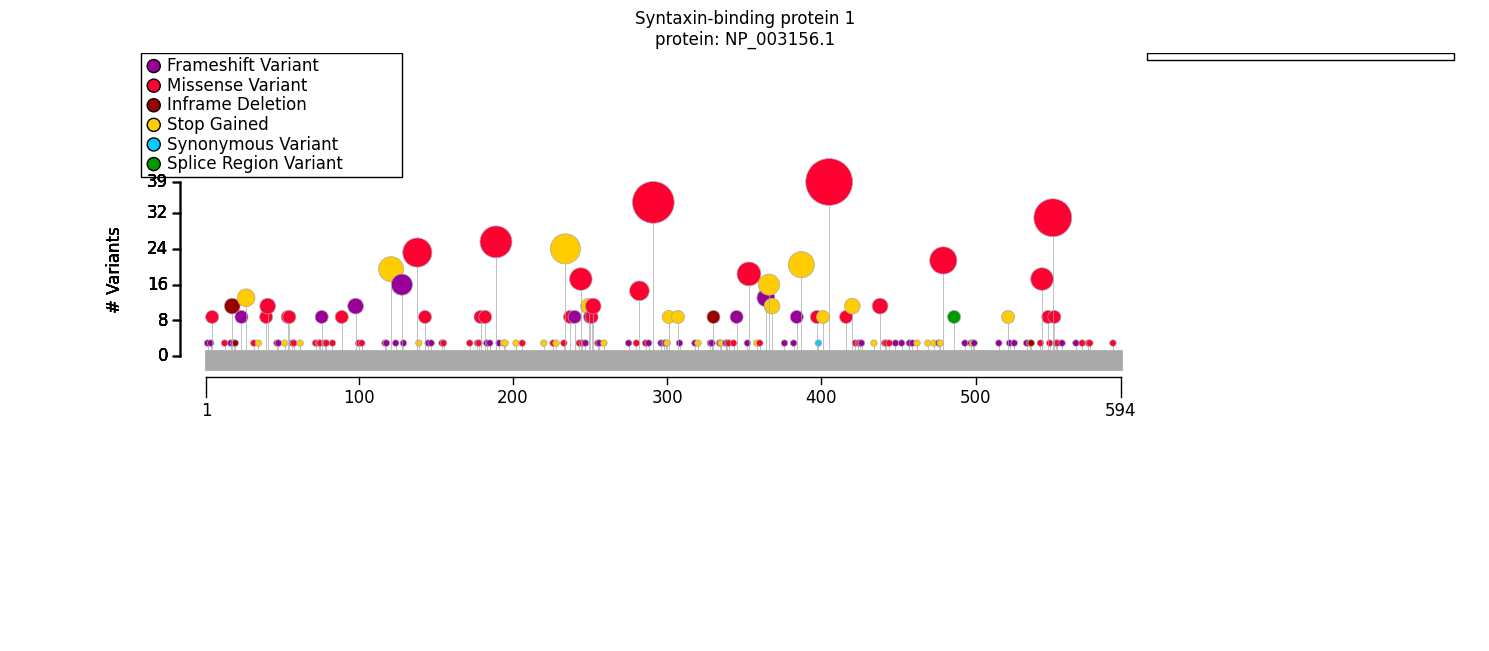

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

stxbp1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
stxbp1_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(report)

Count,Variant key,HGVS,Overlapping Exons,Effects
19,9_127675909_127675909_C_T,c.1216C>T (p.Arg406Cys),14,missense
19,9_127675910_127675910_G_A,c.1217G>A (p.Arg406His),14,missense
18,9_127682509_127682509_C_T,c.1651C>T (p.Arg551Cys),18,missense
18,9_127668160_127668160_G_A,c.875G>A (p.Arg292His),10,missense
12,9_127661192_127661192_C_T,c.416C>T (p.Pro139Leu),6,missense
11,9_127663343_127663343_C_T,c.568C>T (p.Arg190Trp),7,missense
10,9_127675855_127675855_C_T,c.1162C>T (p.Arg388Ter),14,stop gained
10,9_127678510_127678510_C_T,c.1439C>T (p.Pro480Leu),16,missense
10,9_127668159_127668159_C_T,c.874C>T (p.Arg292Cys),10,missense
9,9_127661140_127661140_C_T,c.364C>T (p.Arg122Ter),6,stop gained


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

## Genotype predicate

Test Missense variants vs. the others.


In [10]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,10
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,121
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,815


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
EEG with generalized epileptiform discharges [HP:0011198],100/100 (100%),99/99 (100%),1.0,1.0
EEG with focal epileptiform discharges [HP:0011185],108/108 (100%),86/86 (100%),1.0,1.0
Intellectual disability [HP:0001249],109/109 (100%),100/100 (100%),1.0,1.0
Abnormal muscle tone [HP:0003808],112/112 (100%),115/115 (100%),1.0,1.0
Delayed speech and language development [HP:0000750],114/114 (100%),100/100 (100%),1.0,1.0
Abnormal speech pattern [HP:0002167],116/116 (100%),102/102 (100%),1.0,1.0
Language impairment [HP:0002463],118/118 (100%),103/103 (100%),1.0,1.0
Abnormal communication [HP:0034434],123/123 (100%),107/107 (100%),1.0,1.0
Focal-onset seizure [HP:0007359],124/124 (100%),103/103 (100%),1.0,1.0
Motor seizure [HP:0020219],161/161 (100%),143/143 (100%),1.0,1.0


In [12]:
from gpsea.analysis.predicate import variant_key, anyof


r406h = variant_key("9_127675910_127675910_G_A") #c.1217G>A	p.Arg406His	
r406c = variant_key("9_127675909_127675909_C_T") #9_127675909_127675909_C_T

r406 = anyof((r406c, r406h))

r406_clf = monoallelic_classifier(
    a_predicate=r406,
    b_predicate=~r406,
    a_label="Arg406 Variants",
    b_label="Other"
)

r406_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r406_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=r406_result)

Allele group,Arg406 Variants,Other,Corrected p values,p values
EEG with focal epileptiform discharges [HP:0011185],14/14 (100%),180/180 (100%),1.0,1.0
Intellectual disability [HP:0001249],16/16 (100%),193/193 (100%),1.0,1.0
Focal-onset seizure [HP:0007359],16/16 (100%),211/211 (100%),1.0,1.0
Epileptic spasm [HP:0011097],17/17 (100%),174/174 (100%),1.0,1.0
Abnormal muscle tone [HP:0003808],19/19 (100%),208/208 (100%),1.0,1.0
Delayed speech and language development [HP:0000750],21/21 (100%),193/193 (100%),1.0,1.0
Abnormal speech pattern [HP:0002167],21/21 (100%),197/197 (100%),1.0,1.0
Language impairment [HP:0002463],21/21 (100%),200/200 (100%),1.0,1.0
Abnormal communication [HP:0034434],21/21 (100%),209/209 (100%),1.0,1.0
EEG with generalized epileptiform discharges [HP:0011198],25/25 (100%),174/174 (100%),1.0,1.0


In [13]:
from gpsea.analysis.predicate import exon
exon_14 = exon(14, mane_tx_id)
gt_14_clf = monoallelic_classifier(
    a_predicate=exon_14,
    a_label="Exon 14",
    b_label="Other"
)

result_14 = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_14_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=result_14)

Allele group,Exon 14,Other,Corrected p values,p values
EEG with focal epileptiform discharges [HP:0011185],22/22 (100%),172/172 (100%),1.0,1.0
Intellectual disability [HP:0001249],22/22 (100%),187/187 (100%),1.0,1.0
Epileptic spasm [HP:0011097],25/25 (100%),166/166 (100%),1.0,1.0
Focal-onset seizure [HP:0007359],25/25 (100%),202/202 (100%),1.0,1.0
Delayed speech and language development [HP:0000750],29/29 (100%),185/185 (100%),1.0,1.0
Abnormal speech pattern [HP:0002167],30/30 (100%),188/188 (100%),1.0,1.0
Language impairment [HP:0002463],31/31 (100%),190/190 (100%),1.0,1.0
Abnormal muscle tone [HP:0003808],32/32 (100%),195/195 (100%),1.0,1.0
Abnormal communication [HP:0034434],32/32 (100%),198/198 (100%),1.0,1.0
EEG with generalized epileptiform discharges [HP:0011198],33/33 (100%),166/166 (100%),1.0,1.0


# Summary

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=r406_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=result_14,
    ),
)

caption = """No significant genotype-phenotype correlations identified."""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,18,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Arg406 Variants,Other,18,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Exon 14,Other,18,0


In [18]:
summarizer.process_latex(report=report, protein_fig=stxbp1_fig)

Figure saved to ../../supplement/img/STXBP1_protein_diagram-draft.pdf
Output to ../../supplement/tex/STXBP1_summary_draft.tex
